In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#"gdrive/My Drive/svhn/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Config

In [0]:
from pprint import pprint


# Default Configs for training
# NOTE that, config items could be overwriten by passing argument through command line.
# e.g. --voc-data-dir='./data/'

class Config:
    # data
    voc_data_dir = 'gdrive/My Drive/svhn/data/VOCdevkit/VOC2007/'
    min_size = 600  # image resize
    max_size = 1000 # image resize
    num_workers = 8
    test_num_workers = 8

    # sigma for l1_smooth_loss
    rpn_sigma = 3.
    roi_sigma = 1.

    # param for optimizer
    # 0.0005 in origin paper but 0.0001 in tf-faster-rcnn
    weight_decay = 0.0005
    lr_decay = 0.1  # 1e-3 -> 1e-4
    lr = 1e-3


    # visualization
    env = 'faster-rcnn'  # visdom env
    port = 8097
    plot_every = 40  # vis every N iter

    # preset
    data = 'voc'
    pretrained_model = 'vgg16'

    # training
    epoch = 14


    use_adam = False # Use Adam optimizer
    use_chainer = False # try match everything as chainer
    use_drop = False # use dropout in RoIHead
    # debug
    debug_file = '/tmp/debugf'

    test_num = 10000
    # model
    load_path = None

    caffe_pretrain = False # use caffe pretrained model instead of torchvision
    caffe_pretrain_path = 'checkpoints/vgg16_caffe.pth'

    def _parse(self, kwargs):
        state_dict = self._state_dict()
        for k, v in kwargs.items():
            if k not in state_dict:
                raise ValueError('UnKnown Option: "--%s"' % k)
            setattr(self, k, v)

        print('======user config========')
        pprint(self._state_dict())
        print('==========end============')

    def _state_dict(self):
        return {k: getattr(self, k) for k, _ in Config.__dict__.items() \
                if not k.startswith('_')}


opt = Config()


# Dataset

## data.util

In [0]:
import numpy as np
from PIL import Image
import random


def read_image(path, dtype=np.float32, color=True):
    """Read an image from a file.

    This function reads an image from given file. The image is CHW format and
    the range of its value is :math:`[0, 255]`. If :obj:`color = True`, the
    order of the channels is RGB.

    Args:
        path (str): A path of image file.
        dtype: The type of array. The default value is :obj:`~numpy.float32`.
        color (bool): This option determines the number of channels.
            If :obj:`True`, the number of channels is three. In this case,
            the order of the channels is RGB. This is the default behaviour.
            If :obj:`False`, this function returns a grayscale image.

    Returns:
        ~numpy.ndarray: An image.
    """

    f = Image.open(path)
    try:
        if color:
            img = f.convert('RGB')
        else:
            img = f.convert('P')
        img = np.asarray(img, dtype=dtype)
    finally:
        if hasattr(f, 'close'):
            f.close()

    if img.ndim == 2:
        # reshape (H, W) -> (1, H, W)
        return img[np.newaxis]
    else:
        # transpose (H, W, C) -> (C, H, W)
        return img.transpose((2, 0, 1))


def resize_bbox(bbox, in_size, out_size):
    """Resize bounding boxes according to image resize.

    The bounding boxes are expected to be packed into a two dimensional
    tensor of shape :math:`(R, 4)`, where :math:`R` is the number of
    bounding boxes in the image. The second axis represents attributes of
    the bounding box. They are :math:`(y_{min}, x_{min}, y_{max}, x_{max})`,
    where the four attributes are coordinates of the top left and the
    bottom right vertices.

    Args:
        bbox (~numpy.ndarray): An array whose shape is :math:`(R, 4)`.
            :math:`R` is the number of bounding boxes.
        in_size (tuple): A tuple of length 2. The height and the width
            of the image before resized.
        out_size (tuple): A tuple of length 2. The height and the width
            of the image after resized.

    Returns:
        ~numpy.ndarray:
        Bounding boxes rescaled according to the given image shapes.

    """
    bbox = bbox.copy()
    y_scale = float(out_size[0]) / in_size[0]
    x_scale = float(out_size[1]) / in_size[1]
    bbox[:, 0] = y_scale * bbox[:, 0]
    bbox[:, 2] = y_scale * bbox[:, 2]
    bbox[:, 1] = x_scale * bbox[:, 1]
    bbox[:, 3] = x_scale * bbox[:, 3]
    return bbox


def flip_bbox(bbox, size, y_flip=False, x_flip=False):
    """Flip bounding boxes accordingly.

    The bounding boxes are expected to be packed into a two dimensional
    tensor of shape :math:`(R, 4)`, where :math:`R` is the number of
    bounding boxes in the image. The second axis represents attributes of
    the bounding box. They are :math:`(y_{min}, x_{min}, y_{max}, x_{max})`,
    where the four attributes are coordinates of the top left and the
    bottom right vertices.

    Args:
        bbox (~numpy.ndarray): An array whose shape is :math:`(R, 4)`.
            :math:`R` is the number of bounding boxes.
        size (tuple): A tuple of length 2. The height and the width
            of the image before resized.
        y_flip (bool): Flip bounding box according to a vertical flip of
            an image.
        x_flip (bool): Flip bounding box according to a horizontal flip of
            an image.

    Returns:
        ~numpy.ndarray:
        Bounding boxes flipped according to the given flips.

    """
    H, W = size
    bbox = bbox.copy()
    if y_flip:
        y_max = H - bbox[:, 0]
        y_min = H - bbox[:, 2]
        bbox[:, 0] = y_min
        bbox[:, 2] = y_max
    if x_flip:
        x_max = W - bbox[:, 1]
        x_min = W - bbox[:, 3]
        bbox[:, 1] = x_min
        bbox[:, 3] = x_max
    return bbox


def crop_bbox(
        bbox, y_slice=None, x_slice=None,
        allow_outside_center=True, return_param=False):
    """Translate bounding boxes to fit within the cropped area of an image.

    This method is mainly used together with image cropping.
    This method translates the coordinates of bounding boxes like
    :func:`data.util.translate_bbox`. In addition,
    this function truncates the bounding boxes to fit within the cropped area.
    If a bounding box does not overlap with the cropped area,
    this bounding box will be removed.

    The bounding boxes are expected to be packed into a two dimensional
    tensor of shape :math:`(R, 4)`, where :math:`R` is the number of
    bounding boxes in the image. The second axis represents attributes of
    the bounding box. They are :math:`(y_{min}, x_{min}, y_{max}, x_{max})`,
    where the four attributes are coordinates of the top left and the
    bottom right vertices.

    Args:
        bbox (~numpy.ndarray): Bounding boxes to be transformed. The shape is
            :math:`(R, 4)`. :math:`R` is the number of bounding boxes.
        y_slice (slice): The slice of y axis.
        x_slice (slice): The slice of x axis.
        allow_outside_center (bool): If this argument is :obj:`False`,
            bounding boxes whose centers are outside of the cropped area
            are removed. The default value is :obj:`True`.
        return_param (bool): If :obj:`True`, this function returns
            indices of kept bounding boxes.

    Returns:
        ~numpy.ndarray or (~numpy.ndarray, dict):

        If :obj:`return_param = False`, returns an array :obj:`bbox`.

        If :obj:`return_param = True`,
        returns a tuple whose elements are :obj:`bbox, param`.
        :obj:`param` is a dictionary of intermediate parameters whose
        contents are listed below with key, value-type and the description
        of the value.

        * **index** (*numpy.ndarray*): An array holding indices of used \
            bounding boxes.

    """

    t, b = _slice_to_bounds(y_slice)
    l, r = _slice_to_bounds(x_slice)
    crop_bb = np.array((t, l, b, r))

    if allow_outside_center:
        mask = np.ones(bbox.shape[0], dtype=bool)
    else:
        center = (bbox[:, :2] + bbox[:, 2:]) / 2.0
        mask = np.logical_and(crop_bb[:2] <= center, center < crop_bb[2:]) \
            .all(axis=1)

    bbox = bbox.copy()
    bbox[:, :2] = np.maximum(bbox[:, :2], crop_bb[:2])
    bbox[:, 2:] = np.minimum(bbox[:, 2:], crop_bb[2:])
    bbox[:, :2] -= crop_bb[:2]
    bbox[:, 2:] -= crop_bb[:2]

    mask = np.logical_and(mask, (bbox[:, :2] < bbox[:, 2:]).all(axis=1))
    bbox = bbox[mask]

    if return_param:
        return bbox, {'index': np.flatnonzero(mask)}
    else:
        return bbox


def _slice_to_bounds(slice_):
    if slice_ is None:
        return 0, np.inf

    if slice_.start is None:
        l = 0
    else:
        l = slice_.start

    if slice_.stop is None:
        u = np.inf
    else:
        u = slice_.stop

    return l, u


def translate_bbox(bbox, y_offset=0, x_offset=0):
    """Translate bounding boxes.

    This method is mainly used together with image transforms, such as padding
    and cropping, which translates the left top point of the image from
    coordinate :math:`(0, 0)` to coordinate
    :math:`(y, x) = (y_{offset}, x_{offset})`.

    The bounding boxes are expected to be packed into a two dimensional
    tensor of shape :math:`(R, 4)`, where :math:`R` is the number of
    bounding boxes in the image. The second axis represents attributes of
    the bounding box. They are :math:`(y_{min}, x_{min}, y_{max}, x_{max})`,
    where the four attributes are coordinates of the top left and the
    bottom right vertices.

    Args:
        bbox (~numpy.ndarray): Bounding boxes to be transformed. The shape is
            :math:`(R, 4)`. :math:`R` is the number of bounding boxes.
        y_offset (int or float): The offset along y axis.
        x_offset (int or float): The offset along x axis.

    Returns:
        ~numpy.ndarray:
        Bounding boxes translated according to the given offsets.

    """

    out_bbox = bbox.copy()
    out_bbox[:, :2] += (y_offset, x_offset)
    out_bbox[:, 2:] += (y_offset, x_offset)

    return out_bbox


def random_flip(img, y_random=False, x_random=False,
                return_param=False, copy=False):
    """Randomly flip an image in vertical or horizontal direction.

    Args:
        img (~numpy.ndarray): An array that gets flipped. This is in
            CHW format.
        y_random (bool): Randomly flip in vertical direction.
        x_random (bool): Randomly flip in horizontal direction.
        return_param (bool): Returns information of flip.
        copy (bool): If False, a view of :obj:`img` will be returned.

    Returns:
        ~numpy.ndarray or (~numpy.ndarray, dict):

        If :obj:`return_param = False`,
        returns an array :obj:`out_img` that is the result of flipping.

        If :obj:`return_param = True`,
        returns a tuple whose elements are :obj:`out_img, param`.
        :obj:`param` is a dictionary of intermediate parameters whose
        contents are listed below with key, value-type and the description
        of the value.

        * **y_flip** (*bool*): Whether the image was flipped in the\
            vertical direction or not.
        * **x_flip** (*bool*): Whether the image was flipped in the\
            horizontal direction or not.

    """
    y_flip, x_flip = False, False
    if y_random:
        y_flip = random.choice([True, False])
    if x_random:
        x_flip = random.choice([True, False])

    if y_flip:
        img = img[:, ::-1, :]
    if x_flip:
        img = img[:, :, ::-1]

    if copy:
        img = img.copy()

    if return_param:
        return img, {'y_flip': y_flip, 'x_flip': x_flip}
    else:
        return img


## data.voc_dataset

In [0]:
import os
import xml.etree.ElementTree as ET

import numpy as np

#from .util import read_image


class VOCBboxDataset:

    def __init__(self, data_dir, split='trainval',
                 use_difficult=False, return_difficult=False,
                 ):
        id_list_file = os.path.join(
            data_dir, 'ImageSets/Main/{0}.txt'.format(split))

        self.ids = [id_.strip() for id_ in open(id_list_file)]
        self.data_dir = data_dir
        self.use_difficult = use_difficult
        self.return_difficult = return_difficult
        self.label_names = VOC_BBOX_LABEL_NAMES

    def __len__(self):
        return len(self.ids)

    def get_example(self, i):
        id_ = self.ids[i]
        anno = ET.parse(
            os.path.join(self.data_dir, 'Annotations', id_ + '.xml'))
        bbox = list()
        label = list()
        difficult = list()
        for obj in anno.findall('object'):
            # when in not using difficult split, and the object is
            # difficult, skipt it.
            if not self.use_difficult and int(obj.find('difficult').text) == 1:
                continue

            difficult.append(int(obj.find('difficult').text))
            bndbox_anno = obj.find('bndbox')
            # subtract 1 to make pixel indexes 0-based
            bbox.append([
                int(bndbox_anno.find(tag).text) - 1
                for tag in ('ymin', 'xmin', 'ymax', 'xmax')])
            name = obj.find('name').text.lower().strip()
            label.append(VOC_BBOX_LABEL_NAMES.index(name))
        bbox = np.stack(bbox).astype(np.float32)
        label = np.stack(label).astype(np.int32)
        # When `use_difficult==False`, all elements in `difficult` are False.
        difficult = np.array(difficult, dtype=np.bool).astype(np.uint8)  # PyTorch don't support np.bool

        # Load a image
        img_file = os.path.join(self.data_dir, 'JPEGImages', id_ + '.jpg')
        img = read_image(img_file, color=True)

        # if self.return_difficult:
        #     return img, bbox, label, difficult
        return img, bbox, label, difficult

    __getitem__ = get_example


VOC_BBOX_LABEL_NAMES = (
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor')


## data.dataset

In [0]:
import torch as t
#from data.voc_dataset import VOCBboxDataset
from skimage import transform as sktsf
from torchvision import transforms as tvtsf
#from data import util
import numpy as np
#from utils.config import opt


def inverse_normalize(img):
    if opt.caffe_pretrain:
        img = img + (np.array([122.7717, 115.9465, 102.9801]).reshape(3, 1, 1))
        return img[::-1, :, :]
    # approximate un-normalize for visualize
    return (img * 0.225 + 0.45).clip(min=0, max=1) * 255


def pytorch_normalze(img):
    """
    https://github.com/pytorch/vision/issues/223
    return appr -1~1 RGB
    """
    normalize = tvtsf.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    img = normalize(t.from_numpy(img))
    return img.numpy()


def caffe_normalize(img):
    """
    return appr -125-125 BGR
    """
    img = img[[2, 1, 0], :, :]  # RGB-BGR
    img = img * 255
    mean = np.array([122.7717, 115.9465, 102.9801]).reshape(3, 1, 1)
    img = (img - mean).astype(np.float32, copy=True)
    return img


def preprocess(img, min_size=600, max_size=1000):
    C, H, W = img.shape
    scale1 = min_size / min(H, W)
    scale2 = max_size / max(H, W)
    scale = min(scale1, scale2)
    img = img / 255.
    img = sktsf.resize(img, (C, H * scale, W * scale), mode='reflect',anti_aliasing=False)
    # both the longer and shorter should be less than
    # max_size and min_size
    img = img.astype(np.float32) ###### added
    if opt.caffe_pretrain:
        normalize = caffe_normalize
    else:
        normalize = pytorch_normalze
    return normalize(img)


class Transform(object):

    def __init__(self, min_size=600, max_size=1000):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, in_data):
        img, bbox, label = in_data
        _, H, W = img.shape
        img = preprocess(img, self.min_size, self.max_size)
        _, o_H, o_W = img.shape
        scale = o_H / H
        bbox = resize_bbox(bbox, (H, W), (o_H, o_W))

        # horizontally flip
        img, params = random_flip(
            img, x_random=True, return_param=True)
        bbox = flip_bbox(
            bbox, (o_H, o_W), x_flip=params['x_flip'])

        return img, bbox, label, scale


class Dataset:
    def __init__(self, opt):
        self.opt = opt
        self.db = VOCBboxDataset(opt.voc_data_dir)
        self.tsf = Transform(opt.min_size, opt.max_size)

    def __getitem__(self, idx):
        ori_img, bbox, label, difficult = self.db.get_example(idx)

        img, bbox, label, scale = self.tsf((ori_img, bbox, label))
        # TODO: check whose stride is negative to fix this instead copy all
        # some of the strides of a given numpy array are negative.
        return img.copy(), bbox.copy(), label.copy(), scale

    def __len__(self):
        return len(self.db)


class TestDataset:
    def __init__(self, opt, split='test', use_difficult=True):
        self.opt = opt
        self.db = VOCBboxDataset(opt.voc_data_dir, split=split, use_difficult=use_difficult)

    def __getitem__(self, idx):
        ori_img, bbox, label, difficult = self.db.get_example(idx)
        img = preprocess(ori_img)
        return img, ori_img.shape[1:], bbox, label, difficult

    def __len__(self):
        return len(self.db)


## SVHN dataset

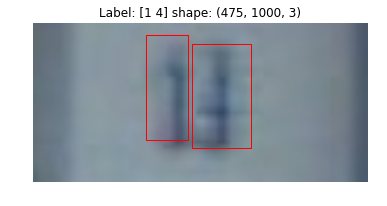

In [28]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import skimage.transform as sktransform
import matplotlib.pylab as plt
import json

class Transform():
    
    def __init__(self, min_size=600, max_size=1000):
        self.min_size = min_size
        self.max_size = max_size
        
    def __call__(self, data):
        img, bbox = data
        
        img = img.transpose(2, 0, 1)
        img = img/255.
        # img resize
        c, h, w = img.shape
        smin, smax = self.min_size/min(h, w), self.max_size/max(h, w)
        scale = min(smin, smax)
        img = sktransform.resize(img, (c, h*scale, w*scale))
        
        # img normalize
        img = transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])(torch.from_numpy(img).float()).numpy().astype(np.float32)
        
        # bbox resize
        bbox = bbox * scale
        bbox = bbox[:, (1, 0, 3, 2)]
        bbox[:, 2] = bbox[:, 0] + bbox[:, 2]
        bbox[:, 3] = bbox[:, 1] + bbox[:, 3]
        return img, bbox, scale


class TrainValSet(Dataset):

    def __init__(self, root, info='digitStruct.json'):
        self.root = root
        info_path = root+'/'+info
        with open(info_path, 'r') as f:
            self.data_info = json.load(f)
        self.transform = Transform()
    
    def __len__(self):
        return len(self.data_info)
    
    def __getitem__(self, idx):
        img_path = self.root+'/'+self.data_info[idx]['name']
        img = io.imread(img_path)
        
        bbox = np.asarray(self.data_info[idx]['bbox']).astype(np.float32)
        label = np.asarray(self.data_info[idx]['label']).astype(np.int32)
        label[label==10]=0 # 0 is labeled as 10 in svhn 
        
        img, bbox, scale = self.transform((img, bbox))
        
        return img, bbox, label, scale


def denormalize(img):
    return (img * 0.225 + 0.45).clip(0, 1) 


def show_item(item):
    img, bbox, label, scale = item
    img = img.transpose(1, 2, 0)
    img = denormalize(img)
    
    title = 'Label: '+ str(label)+" shape: " + str(img.shape)
    
    plt.figure()
    plt.title(title)
    plt.imshow(img)
    ax = plt.gca()
    for i in range(bbox.shape[0]):
        xy = (bbox[i, 1], bbox[i, 0])
        w, h = bbox[i, 3]-bbox[i, 1], bbox[i, 2]-bbox[i, 0]
        rect = plt.Rectangle(xy, w, h, fill=False, edgecolor = 'red',linewidth=1)
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()


test = TrainValSet('gdrive/My Drive/svhn/data/train')
show_item(test[np.random.randint(0, len(test))])

## Test Dataset

In [12]:
from torch.utils.data import DataLoader


dataset = Dataset(opt)
img, bbox, label, scale = dataset[731]
print(img.shape, img.dtype)
print(bbox.shape, bbox.dtype)
print(label.shape, label.dtype)
print(scale, type(scale))

dataloader = DataLoader(dataset, batch_size=1, 
                        shuffle=True, num_workers=opt.num_workers)

dataiter = iter(dataloader)
img, bbox_, label_, scale = dataiter.next()
print(img.shape, img.dtype)
print(bbox_.shape, bbox_.dtype)
print(label_.shape, label_.dtype)
print(scale.shape, scale.dtype)

testset = TestDataset(opt)
test_dataloader = DataLoader(testset, batch_size=1, 
                             num_workers=opt.test_num_workers,
                             shuffle=False, pin_memory=True)

dataiter = iter(test_dataloader)
imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_ = dataiter.next()
sizes = [sizes[0][0].item(), sizes[1][0].item()]
for img_, size_ in zip(imgs, [sizes]):
    print(img_.shape)
    print(size_)

(3, 600, 829) float32
(2, 4) float32
(2,) int32
1.6574585635359116 <class 'float'>
torch.Size([1, 3, 600, 904]) torch.float32
torch.Size([1, 1, 4]) torch.float32
torch.Size([1, 1]) torch.int32
torch.Size([1]) torch.float64


# Model

## model.utils.bbox_tools

In [0]:
import numpy as np
import numpy as xp


def loc2bbox(src_bbox, loc):
    """Decode bounding boxes from bounding box offsets and scales.

    Given bounding box offsets and scales computed by
    :meth:`bbox2loc`, this function decodes the representation to
    coordinates in 2D image coordinates.

    Given scales and offsets :math:`t_y, t_x, t_h, t_w` and a bounding
    box whose center is :math:`(y, x) = p_y, p_x` and size :math:`p_h, p_w`,
    the decoded bounding box's center :math:`\\hat{g}_y`, :math:`\\hat{g}_x`
    and size :math:`\\hat{g}_h`, :math:`\\hat{g}_w` are calculated
    by the following formulas.

    * :math:`\\hat{g}_y = p_h t_y + p_y`
    * :math:`\\hat{g}_x = p_w t_x + p_x`
    * :math:`\\hat{g}_h = p_h \\exp(t_h)`
    * :math:`\\hat{g}_w = p_w \\exp(t_w)`

    The decoding formulas are used in works such as R-CNN [#]_.

    The output is same type as the type of the inputs.

    .. [#] Ross Girshick, Jeff Donahue, Trevor Darrell, Jitendra Malik. \
    Rich feature hierarchies for accurate object detection and semantic \
    segmentation. CVPR 2014.

    Args:
        src_bbox (array): A coordinates of bounding boxes.
            Its shape is :math:`(R, 4)`. These coordinates are
            :math:`p_{ymin}, p_{xmin}, p_{ymax}, p_{xmax}`.
        loc (array): An array with offsets and scales.
            The shapes of :obj:`src_bbox` and :obj:`loc` should be same.
            This contains values :math:`t_y, t_x, t_h, t_w`.

    Returns:
        array:
        Decoded bounding box coordinates. Its shape is :math:`(R, 4)`. \
        The second axis contains four values \
        :math:`\\hat{g}_{ymin}, \\hat{g}_{xmin},
        \\hat{g}_{ymax}, \\hat{g}_{xmax}`.

    """

    if src_bbox.shape[0] == 0:
        return xp.zeros((0, 4), dtype=loc.dtype)

    src_bbox = src_bbox.astype(src_bbox.dtype, copy=False)

    src_height = src_bbox[:, 2] - src_bbox[:, 0]
    src_width = src_bbox[:, 3] - src_bbox[:, 1]
    src_ctr_y = src_bbox[:, 0] + 0.5 * src_height
    src_ctr_x = src_bbox[:, 1] + 0.5 * src_width

    dy = loc[:, 0::4]
    dx = loc[:, 1::4]
    dh = loc[:, 2::4]
    dw = loc[:, 3::4]

    ctr_y = dy * src_height[:, xp.newaxis] + src_ctr_y[:, xp.newaxis]
    ctr_x = dx * src_width[:, xp.newaxis] + src_ctr_x[:, xp.newaxis]
    h = xp.exp(dh) * src_height[:, xp.newaxis]
    w = xp.exp(dw) * src_width[:, xp.newaxis]

    dst_bbox = xp.zeros(loc.shape, dtype=loc.dtype)
    dst_bbox[:, 0::4] = ctr_y - 0.5 * h
    dst_bbox[:, 1::4] = ctr_x - 0.5 * w
    dst_bbox[:, 2::4] = ctr_y + 0.5 * h
    dst_bbox[:, 3::4] = ctr_x + 0.5 * w

    return dst_bbox


def bbox2loc(src_bbox, dst_bbox):
    """Encodes the source and the destination bounding boxes to "loc".

    Given bounding boxes, this function computes offsets and scales
    to match the source bounding boxes to the target bounding boxes.
    Mathematcially, given a bounding box whose center is
    :math:`(y, x) = p_y, p_x` and
    size :math:`p_h, p_w` and the target bounding box whose center is
    :math:`g_y, g_x` and size :math:`g_h, g_w`, the offsets and scales
    :math:`t_y, t_x, t_h, t_w` can be computed by the following formulas.

    * :math:`t_y = \\frac{(g_y - p_y)} {p_h}`
    * :math:`t_x = \\frac{(g_x - p_x)} {p_w}`
    * :math:`t_h = \\log(\\frac{g_h} {p_h})`
    * :math:`t_w = \\log(\\frac{g_w} {p_w})`

    The output is same type as the type of the inputs.
    The encoding formulas are used in works such as R-CNN [#]_.

    .. [#] Ross Girshick, Jeff Donahue, Trevor Darrell, Jitendra Malik. \
    Rich feature hierarchies for accurate object detection and semantic \
    segmentation. CVPR 2014.

    Args:
        src_bbox (array): An image coordinate array whose shape is
            :math:`(R, 4)`. :math:`R` is the number of bounding boxes.
            These coordinates are
            :math:`p_{ymin}, p_{xmin}, p_{ymax}, p_{xmax}`.
        dst_bbox (array): An image coordinate array whose shape is
            :math:`(R, 4)`.
            These coordinates are
            :math:`g_{ymin}, g_{xmin}, g_{ymax}, g_{xmax}`.

    Returns:
        array:
        Bounding box offsets and scales from :obj:`src_bbox` \
        to :obj:`dst_bbox`. \
        This has shape :math:`(R, 4)`.
        The second axis contains four values :math:`t_y, t_x, t_h, t_w`.

    """

    height = src_bbox[:, 2] - src_bbox[:, 0]
    width = src_bbox[:, 3] - src_bbox[:, 1]
    ctr_y = src_bbox[:, 0] + 0.5 * height
    ctr_x = src_bbox[:, 1] + 0.5 * width

    base_height = dst_bbox[:, 2] - dst_bbox[:, 0]
    base_width = dst_bbox[:, 3] - dst_bbox[:, 1]
    base_ctr_y = dst_bbox[:, 0] + 0.5 * base_height
    base_ctr_x = dst_bbox[:, 1] + 0.5 * base_width

    eps = xp.finfo(height.dtype).eps
    height = xp.maximum(height, eps)
    width = xp.maximum(width, eps)

    dy = (base_ctr_y - ctr_y) / height
    dx = (base_ctr_x - ctr_x) / width
    dh = xp.log(base_height / height)
    dw = xp.log(base_width / width)

    loc = xp.vstack((dy, dx, dh, dw)).transpose()
    return loc


def bbox_iou(bbox_a, bbox_b):
    """Calculate the Intersection of Unions (IoUs) between bounding boxes.

    IoU is calculated as a ratio of area of the intersection
    and area of the union.

    This function accepts both :obj:`numpy.ndarray` and :obj:`cupy.ndarray` as
    inputs. Please note that both :obj:`bbox_a` and :obj:`bbox_b` need to be
    same type.
    The output is same type as the type of the inputs.

    Args:
        bbox_a (array): An array whose shape is :math:`(N, 4)`.
            :math:`N` is the number of bounding boxes.
            The dtype should be :obj:`numpy.float32`.
        bbox_b (array): An array similar to :obj:`bbox_a`,
            whose shape is :math:`(K, 4)`.
            The dtype should be :obj:`numpy.float32`.

    Returns:
        array:
        An array whose shape is :math:`(N, K)`. \
        An element at index :math:`(n, k)` contains IoUs between \
        :math:`n` th bounding box in :obj:`bbox_a` and :math:`k` th bounding \
        box in :obj:`bbox_b`.

    """
    if bbox_a.shape[1] != 4 or bbox_b.shape[1] != 4:
        raise IndexError

    # top left
    tl = xp.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    # bottom right
    br = xp.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])

    area_i = xp.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = xp.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = xp.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)


def generate_anchor_base(base_size=16, ratios=[0.5, 1, 2],
                         anchor_scales=[8, 16, 32]):
    """Generate anchor base windows by enumerating aspect ratio and scales.

    Generate anchors that are scaled and modified to the given aspect ratios.
    Area of a scaled anchor is preserved when modifying to the given aspect
    ratio.

    :obj:`R = len(ratios) * len(anchor_scales)` anchors are generated by this
    function.
    The :obj:`i * len(anchor_scales) + j` th anchor corresponds to an anchor
    generated by :obj:`ratios[i]` and :obj:`anchor_scales[j]`.

    For example, if the scale is :math:`8` and the ratio is :math:`0.25`,
    the width and the height of the base window will be stretched by :math:`8`.
    For modifying the anchor to the given aspect ratio,
    the height is halved and the width is doubled.

    Args:
        base_size (number): The width and the height of the reference window.
        ratios (list of floats): This is ratios of width to height of
            the anchors.
        anchor_scales (list of numbers): This is areas of anchors.
            Those areas will be the product of the square of an element in
            :obj:`anchor_scales` and the original area of the reference
            window.

    Returns:
        ~numpy.ndarray:
        An array of shape :math:`(R, 4)`.
        Each element is a set of coordinates of a bounding box.
        The second axis corresponds to
        :math:`(y_{min}, x_{min}, y_{max}, x_{max})` of a bounding box.

    """
    py = base_size / 2.
    px = base_size / 2.

    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4),
                           dtype=np.float32)
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])
            w = base_size * anchor_scales[j] * np.sqrt(1. / ratios[i])

            index = i * len(anchor_scales) + j
            anchor_base[index, 0] = py - h / 2.
            anchor_base[index, 1] = px - w / 2.
            anchor_base[index, 2] = py + h / 2.
            anchor_base[index, 3] = px + w / 2.
    return anchor_base


## model.utils.nms.no_maximum_suppression

In [0]:

import numpy as np

def _nms_gpu_post( mask,
                  n_bbox,
                   threads_per_block,
                   col_blocks
                  ):
    n_selection = 0
    one_ull = np.array([1],dtype=np.uint64)
    selection = np.zeros((n_bbox,), dtype=np.int32)
    remv = np.zeros((col_blocks,), dtype=np.uint64)

    for i in range(n_bbox):
        nblock = i // threads_per_block
        inblock = i % threads_per_block

        if not (remv[nblock] & one_ull << inblock):
            selection[n_selection] = i
            n_selection += 1

            index = i * col_blocks
            for j in range(nblock, col_blocks):
                remv[j] |= mask[index + j]
    return selection, n_selection


In [0]:
#from __future__ import division
import numpy as np
import cupy as cp
import torch as t
# try:
#     from ._nms_gpu_post import _nms_gpu_post
# except:
#     import warnings
#     warnings.warn('''
#     the python code for non_maximum_suppression is about 2x slow
#     It is strongly recommended to build cython code: 
#     `cd model/utils/nms/; python3 build.py build_ext --inplace''')
#     from ._nms_gpu_post_py import _nms_gpu_post


@cp.util.memoize(for_each_device=True)
def _load_kernel(kernel_name, code, options=()):
    cp.cuda.runtime.free(0)
    assert isinstance(options, tuple)
    kernel_code = cp.cuda.compile_with_cache(code, options=options)
    return kernel_code.get_function(kernel_name)


def non_maximum_suppression(bbox, thresh, score=None,
                            limit=None):
    """Suppress bounding boxes according to their IoUs.

    This method checks each bounding box sequentially and selects the bounding
    box if the Intersection over Unions (IoUs) between the bounding box and the
    previously selected bounding boxes is less than :obj:`thresh`. This method
    is mainly used as postprocessing of object detection.
    The bounding boxes are selected from ones with higher scores.
    If :obj:`score` is not provided as an argument, the bounding box
    is ordered by its index in ascending order.

    The bounding boxes are expected to be packed into a two dimensional
    tensor of shape :math:`(R, 4)`, where :math:`R` is the number of
    bounding boxes in the image. The second axis represents attributes of
    the bounding box. They are :math:`(y_{min}, x_{min}, y_{max}, x_{max})`,
    where the four attributes are coordinates of the top left and the
    bottom right vertices.

    :obj:`score` is a float array of shape :math:`(R,)`. Each score indicates
    confidence of prediction.

    This function accepts both :obj:`numpy.ndarray` and :obj:`cupy.ndarray` as
    an input. Please note that both :obj:`bbox` and :obj:`score` need to be
    the same type.
    The type of the output is the same as the input.

    Args:
        bbox (array): Bounding boxes to be transformed. The shape is
            :math:`(R, 4)`. :math:`R` is the number of bounding boxes.
        thresh (float): Threshold of IoUs.
        score (array): An array of confidences whose shape is :math:`(R,)`.
        limit (int): The upper bound of the number of the output bounding
            boxes. If it is not specified, this method selects as many
            bounding boxes as possible.

    Returns:
        array:
        An array with indices of bounding boxes that are selected. \
        They are sorted by the scores of bounding boxes in descending \
        order. \
        The shape of this array is :math:`(K,)` and its dtype is\
        :obj:`numpy.int32`. Note that :math:`K \\leq R`.

    """

    return _non_maximum_suppression_gpu(bbox, thresh, score, limit)


def _non_maximum_suppression_gpu(bbox, thresh, score=None, limit=None):
    if len(bbox) == 0:
        return cp.zeros((0,), dtype=np.int32)

    n_bbox = bbox.shape[0]

    if score is not None:
        order = score.argsort()[::-1].astype(np.int32)
    else:
        order = cp.arange(n_bbox, dtype=np.int32)

    sorted_bbox = bbox[order, :]
    selec, n_selec = _call_nms_kernel(
        sorted_bbox, thresh)
    selec = selec[:n_selec]
    selec = order[selec]
    if limit is not None:
        selec = selec[:limit]
    return cp.asnumpy(selec)


_nms_gpu_code = '''
#define DIVUP(m,n) ((m) / (n) + ((m) % (n) > 0))
int const threadsPerBlock = sizeof(unsigned long long) * 8;

__device__
inline float devIoU(float const *const bbox_a, float const *const bbox_b) {
  float top = max(bbox_a[0], bbox_b[0]);
  float bottom = min(bbox_a[2], bbox_b[2]);
  float left = max(bbox_a[1], bbox_b[1]);
  float right = min(bbox_a[3], bbox_b[3]);
  float height = max(bottom - top, 0.f);
  float width = max(right - left, 0.f);
  float area_i = height * width;
  float area_a = (bbox_a[2] - bbox_a[0]) * (bbox_a[3] - bbox_a[1]);
  float area_b = (bbox_b[2] - bbox_b[0]) * (bbox_b[3] - bbox_b[1]);
  return area_i / (area_a + area_b - area_i);
}

extern "C"
__global__
void nms_kernel(const int n_bbox, const float thresh,
                const float *dev_bbox,
                unsigned long long *dev_mask) {
  const int row_start = blockIdx.y;
  const int col_start = blockIdx.x;

  const int row_size =
        min(n_bbox - row_start * threadsPerBlock, threadsPerBlock);
  const int col_size =
        min(n_bbox - col_start * threadsPerBlock, threadsPerBlock);

  __shared__ float block_bbox[threadsPerBlock * 4];
  if (threadIdx.x < col_size) {
    block_bbox[threadIdx.x * 4 + 0] =
        dev_bbox[(threadsPerBlock * col_start + threadIdx.x) * 4 + 0];
    block_bbox[threadIdx.x * 4 + 1] =
        dev_bbox[(threadsPerBlock * col_start + threadIdx.x) * 4 + 1];
    block_bbox[threadIdx.x * 4 + 2] =
        dev_bbox[(threadsPerBlock * col_start + threadIdx.x) * 4 + 2];
    block_bbox[threadIdx.x * 4 + 3] =
        dev_bbox[(threadsPerBlock * col_start + threadIdx.x) * 4 + 3];
  }
  __syncthreads();

  if (threadIdx.x < row_size) {
    const int cur_box_idx = threadsPerBlock * row_start + threadIdx.x;
    const float *cur_box = dev_bbox + cur_box_idx * 4;
    int i = 0;
    unsigned long long t = 0;
    int start = 0;
    if (row_start == col_start) {
      start = threadIdx.x + 1;
    }
    for (i = start; i < col_size; i++) {
      if (devIoU(cur_box, block_bbox + i * 4) >= thresh) {
        t |= 1ULL << i;
      }
    }
    const int col_blocks = DIVUP(n_bbox, threadsPerBlock);
    dev_mask[cur_box_idx * col_blocks + col_start] = t;
  }
}
'''


def _call_nms_kernel(bbox, thresh):
    # PyTorch does not support unsigned long Tensor.
    # Doesn't matter,since it returns ndarray finally.
    # So I'll keep it unmodified.
    n_bbox = bbox.shape[0]
    threads_per_block = 64
    col_blocks = np.ceil(n_bbox / threads_per_block).astype(np.int32)
    blocks = (col_blocks, col_blocks, 1)
    threads = (threads_per_block, 1, 1)

    mask_dev = cp.zeros((n_bbox * col_blocks,), dtype=np.uint64)
    bbox = cp.ascontiguousarray(bbox, dtype=np.float32)
    kern = _load_kernel('nms_kernel', _nms_gpu_code)
    kern(blocks, threads, args=(cp.int32(n_bbox), cp.float32(thresh),
                                bbox, mask_dev))

    mask_host = mask_dev.get()
    selection, n_selec = _nms_gpu_post(
        mask_host, n_bbox, threads_per_block, col_blocks)
    return selection, n_selec


## model.utils.creator_tool

In [0]:
import numpy as np
import cupy as cp

#from model.utils.bbox_tools import bbox2loc, bbox_iou, loc2bbox
#from model.utils.nms import non_maximum_suppression


class ProposalTargetCreator(object):
    """Assign ground truth bounding boxes to given RoIs.

    The :meth:`__call__` of this class generates training targets
    for each object proposal.
    This is used to train Faster RCNN [#]_.

    .. [#] Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun. \
    Faster R-CNN: Towards Real-Time Object Detection with \
    Region Proposal Networks. NIPS 2015.

    Args:
        n_sample (int): The number of sampled regions.
        pos_ratio (float): Fraction of regions that is labeled as a
            foreground.
        pos_iou_thresh (float): IoU threshold for a RoI to be considered as a
            foreground.
        neg_iou_thresh_hi (float): RoI is considered to be the background
            if IoU is in
            [:obj:`neg_iou_thresh_hi`, :obj:`neg_iou_thresh_hi`).
        neg_iou_thresh_lo (float): See above.

    """

    def __init__(self,
                 n_sample=128,
                 pos_ratio=0.25, pos_iou_thresh=0.5,
                 neg_iou_thresh_hi=0.5, neg_iou_thresh_lo=0.0
                 ):
        self.n_sample = n_sample
        self.pos_ratio = pos_ratio
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh_hi = neg_iou_thresh_hi
        self.neg_iou_thresh_lo = neg_iou_thresh_lo  # NOTE:default 0.1 in py-faster-rcnn

    def __call__(self, roi, bbox, label,
                 loc_normalize_mean=(0., 0., 0., 0.),
                 loc_normalize_std=(0.1, 0.1, 0.2, 0.2)):
        """Assigns ground truth to sampled proposals.

        This function samples total of :obj:`self.n_sample` RoIs
        from the combination of :obj:`roi` and :obj:`bbox`.
        The RoIs are assigned with the ground truth class labels as well as
        bounding box offsets and scales to match the ground truth bounding
        boxes. As many as :obj:`pos_ratio * self.n_sample` RoIs are
        sampled as foregrounds.

        Offsets and scales of bounding boxes are calculated using
        :func:`model.utils.bbox_tools.bbox2loc`.
        Also, types of input arrays and output arrays are same.

        Here are notations.

        * :math:`S` is the total number of sampled RoIs, which equals \
            :obj:`self.n_sample`.
        * :math:`L` is number of object classes possibly including the \
            background.

        Args:
            roi (array): Region of Interests (RoIs) from which we sample.
                Its shape is :math:`(R, 4)`
            bbox (array): The coordinates of ground truth bounding boxes.
                Its shape is :math:`(R', 4)`.
            label (array): Ground truth bounding box labels. Its shape
                is :math:`(R',)`. Its range is :math:`[0, L - 1]`, where
                :math:`L` is the number of foreground classes.
            loc_normalize_mean (tuple of four floats): Mean values to normalize
                coordinates of bouding boxes.
            loc_normalize_std (tupler of four floats): Standard deviation of
                the coordinates of bounding boxes.

        Returns:
            (array, array, array):

            * **sample_roi**: Regions of interests that are sampled. \
                Its shape is :math:`(S, 4)`.
            * **gt_roi_loc**: Offsets and scales to match \
                the sampled RoIs to the ground truth bounding boxes. \
                Its shape is :math:`(S, 4)`.
            * **gt_roi_label**: Labels assigned to sampled RoIs. Its shape is \
                :math:`(S,)`. Its range is :math:`[0, L]`. The label with \
                value 0 is the background.

        """
        n_bbox, _ = bbox.shape

        roi = np.concatenate((roi, bbox), axis=0)

        pos_roi_per_image = np.round(self.n_sample * self.pos_ratio)
        iou = bbox_iou(roi, bbox)
        gt_assignment = iou.argmax(axis=1)
        max_iou = iou.max(axis=1)
        # Offset range of classes from [0, n_fg_class - 1] to [1, n_fg_class].
        # The label with value 0 is the background.
        gt_roi_label = label[gt_assignment] + 1

        # Select foreground RoIs as those with >= pos_iou_thresh IoU.
        pos_index = np.where(max_iou >= self.pos_iou_thresh)[0]
        pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
        if pos_index.size > 0:
            pos_index = np.random.choice(
                pos_index, size=pos_roi_per_this_image, replace=False)

        # Select background RoIs as those within
        # [neg_iou_thresh_lo, neg_iou_thresh_hi).
        neg_index = np.where((max_iou < self.neg_iou_thresh_hi) &
                             (max_iou >= self.neg_iou_thresh_lo))[0]
        neg_roi_per_this_image = self.n_sample - pos_roi_per_this_image
        neg_roi_per_this_image = int(min(neg_roi_per_this_image,
                                         neg_index.size))
        if neg_index.size > 0:
            neg_index = np.random.choice(
                neg_index, size=neg_roi_per_this_image, replace=False)

        # The indices that we're selecting (both positive and negative).
        keep_index = np.append(pos_index, neg_index)
        gt_roi_label = gt_roi_label[keep_index]
        gt_roi_label[pos_roi_per_this_image:] = 0  # negative labels --> 0
        sample_roi = roi[keep_index]

        # Compute offsets and scales to match sampled RoIs to the GTs.
        gt_roi_loc = bbox2loc(sample_roi, bbox[gt_assignment[keep_index]])
        gt_roi_loc = ((gt_roi_loc - np.array(loc_normalize_mean, np.float32)
                       ) / np.array(loc_normalize_std, np.float32))

        return sample_roi, gt_roi_loc, gt_roi_label


class AnchorTargetCreator(object):
    """Assign the ground truth bounding boxes to anchors.

    Assigns the ground truth bounding boxes to anchors for training Region
    Proposal Networks introduced in Faster R-CNN [#]_.

    Offsets and scales to match anchors to the ground truth are
    calculated using the encoding scheme of
    :func:`model.utils.bbox_tools.bbox2loc`.

    .. [#] Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun. \
    Faster R-CNN: Towards Real-Time Object Detection with \
    Region Proposal Networks. NIPS 2015.

    Args:
        n_sample (int): The number of regions to produce.
        pos_iou_thresh (float): Anchors with IoU above this
            threshold will be assigned as positive.
        neg_iou_thresh (float): Anchors with IoU below this
            threshold will be assigned as negative.
        pos_ratio (float): Ratio of positive regions in the
            sampled regions.

    """

    def __init__(self,
                 n_sample=256,
                 pos_iou_thresh=0.7, neg_iou_thresh=0.3,
                 pos_ratio=0.5):
        self.n_sample = n_sample
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh = neg_iou_thresh
        self.pos_ratio = pos_ratio

    def __call__(self, bbox, anchor, img_size):
        """Assign ground truth supervision to sampled subset of anchors.

        Types of input arrays and output arrays are same.

        Here are notations.

        * :math:`S` is the number of anchors.
        * :math:`R` is the number of bounding boxes.

        Args:
            bbox (array): Coordinates of bounding boxes. Its shape is
                :math:`(R, 4)`.
            anchor (array): Coordinates of anchors. Its shape is
                :math:`(S, 4)`.
            img_size (tuple of ints): A tuple :obj:`H, W`, which
                is a tuple of height and width of an image.

        Returns:
            (array, array):

            #NOTE: it's scale not only  offset
            * **loc**: Offsets and scales to match the anchors to \
                the ground truth bounding boxes. Its shape is :math:`(S, 4)`.
            * **label**: Labels of anchors with values \
                :obj:`(1=positive, 0=negative, -1=ignore)`. Its shape \
                is :math:`(S,)`.

        """

        img_H, img_W = img_size

        n_anchor = len(anchor)
        inside_index = _get_inside_index(anchor, img_H, img_W)
        anchor = anchor[inside_index]
        argmax_ious, label = self._create_label(
            inside_index, anchor, bbox)

        # compute bounding box regression targets
        loc = bbox2loc(anchor, bbox[argmax_ious])

        # map up to original set of anchors
        label = _unmap(label, n_anchor, inside_index, fill=-1)
        loc = _unmap(loc, n_anchor, inside_index, fill=0)

        return loc, label

    def _create_label(self, inside_index, anchor, bbox):
        # label: 1 is positive, 0 is negative, -1 is dont care
        label = np.empty((len(inside_index),), dtype=np.int32)
        label.fill(-1)

        argmax_ious, max_ious, gt_argmax_ious = \
            self._calc_ious(anchor, bbox, inside_index)

        # assign negative labels first so that positive labels can clobber them
        label[max_ious < self.neg_iou_thresh] = 0

        # positive label: for each gt, anchor with highest iou
        label[gt_argmax_ious] = 1

        # positive label: above threshold IOU
        label[max_ious >= self.pos_iou_thresh] = 1

        # subsample positive labels if we have too many
        n_pos = int(self.pos_ratio * self.n_sample)
        pos_index = np.where(label == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(
                pos_index, size=(len(pos_index) - n_pos), replace=False)
            label[disable_index] = -1

        # subsample negative labels if we have too many
        n_neg = self.n_sample - np.sum(label == 1)
        neg_index = np.where(label == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(
                neg_index, size=(len(neg_index) - n_neg), replace=False)
            label[disable_index] = -1

        return argmax_ious, label

    def _calc_ious(self, anchor, bbox, inside_index):
        # ious between the anchors and the gt boxes
        ious = bbox_iou(anchor, bbox)
        argmax_ious = ious.argmax(axis=1)
        max_ious = ious[np.arange(len(inside_index)), argmax_ious]
        gt_argmax_ious = ious.argmax(axis=0)
        gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
        gt_argmax_ious = np.where(ious == gt_max_ious)[0]

        return argmax_ious, max_ious, gt_argmax_ious


def _unmap(data, count, index, fill=0):
    # Unmap a subset of item (data) back to the original set of items (of
    # size count)

    if len(data.shape) == 1:
        ret = np.empty((count,), dtype=data.dtype)
        ret.fill(fill)
        ret[index] = data
    else:
        ret = np.empty((count,) + data.shape[1:], dtype=data.dtype)
        ret.fill(fill)
        ret[index, :] = data
    return ret


def _get_inside_index(anchor, H, W):
    # Calc indicies of anchors which are located completely inside of the image
    # whose size is speficied.
    index_inside = np.where(
        (anchor[:, 0] >= 0) &
        (anchor[:, 1] >= 0) &
        (anchor[:, 2] <= H) &
        (anchor[:, 3] <= W)
    )[0]
    return index_inside


class ProposalCreator:
    # unNOTE: I'll make it undifferential
    # unTODO: make sure it's ok
    # It's ok
    """Proposal regions are generated by calling this object.

    The :meth:`__call__` of this object outputs object detection proposals by
    applying estimated bounding box offsets
    to a set of anchors.

    This class takes parameters to control number of bounding boxes to
    pass to NMS and keep after NMS.
    If the paramters are negative, it uses all the bounding boxes supplied
    or keep all the bounding boxes returned by NMS.

    This class is used for Region Proposal Networks introduced in
    Faster R-CNN [#]_.

    .. [#] Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun. \
    Faster R-CNN: Towards Real-Time Object Detection with \
    Region Proposal Networks. NIPS 2015.

    Args:
        nms_thresh (float): Threshold value used when calling NMS.
        n_train_pre_nms (int): Number of top scored bounding boxes
            to keep before passing to NMS in train mode.
        n_train_post_nms (int): Number of top scored bounding boxes
            to keep after passing to NMS in train mode.
        n_test_pre_nms (int): Number of top scored bounding boxes
            to keep before passing to NMS in test mode.
        n_test_post_nms (int): Number of top scored bounding boxes
            to keep after passing to NMS in test mode.
        force_cpu_nms (bool): If this is :obj:`True`,
            always use NMS in CPU mode. If :obj:`False`,
            the NMS mode is selected based on the type of inputs.
        min_size (int): A paramter to determine the threshold on
            discarding bounding boxes based on their sizes.

    """

    def __init__(self,
                 parent_model,
                 nms_thresh=0.7,
                 n_train_pre_nms=12000,
                 n_train_post_nms=2000,
                 n_test_pre_nms=6000,
                 n_test_post_nms=300,
                 min_size=16
                 ):
        self.parent_model = parent_model
        self.nms_thresh = nms_thresh
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size

    def __call__(self, loc, score,
                 anchor, img_size, scale=1.):
        """input should  be ndarray
        Propose RoIs.

        Inputs :obj:`loc, score, anchor` refer to the same anchor when indexed
        by the same index.

        On notations, :math:`R` is the total number of anchors. This is equal
        to product of the height and the width of an image and the number of
        anchor bases per pixel.

        Type of the output is same as the inputs.

        Args:
            loc (array): Predicted offsets and scaling to anchors.
                Its shape is :math:`(R, 4)`.
            score (array): Predicted foreground probability for anchors.
                Its shape is :math:`(R,)`.
            anchor (array): Coordinates of anchors. Its shape is
                :math:`(R, 4)`.
            img_size (tuple of ints): A tuple :obj:`height, width`,
                which contains image size after scaling.
            scale (float): The scaling factor used to scale an image after
                reading it from a file.

        Returns:
            array:
            An array of coordinates of proposal boxes.
            Its shape is :math:`(S, 4)`. :math:`S` is less than
            :obj:`self.n_test_post_nms` in test time and less than
            :obj:`self.n_train_post_nms` in train time. :math:`S` depends on
            the size of the predicted bounding boxes and the number of
            bounding boxes discarded by NMS.

        """
        # NOTE: when test, remember
        # faster_rcnn.eval()
        # to set self.traing = False
        if self.parent_model.training:
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else:
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        # Convert anchors into proposal via bbox transformations.
        # roi = loc2bbox(anchor, loc)
        roi = loc2bbox(anchor, loc)

        # Clip predicted boxes to image.
        roi[:, slice(0, 4, 2)] = np.clip(
            roi[:, slice(0, 4, 2)], 0, img_size[0])
        roi[:, slice(1, 4, 2)] = np.clip(
            roi[:, slice(1, 4, 2)], 0, img_size[1])

        # Remove predicted boxes with either height or width < threshold.
        min_size = self.min_size * scale
        hs = roi[:, 2] - roi[:, 0]
        ws = roi[:, 3] - roi[:, 1]
        keep = np.where((hs >= min_size) & (ws >= min_size))[0]
        roi = roi[keep, :]
        score = score[keep]

        # Sort all (proposal, score) pairs by score from highest to lowest.
        # Take top pre_nms_topN (e.g. 6000).
        order = score.ravel().argsort()[::-1]
        if n_pre_nms > 0:
            order = order[:n_pre_nms]
        roi = roi[order, :]

        # Apply nms (e.g. threshold = 0.7).
        # Take after_nms_topN (e.g. 300).

        # unNOTE: somthing is wrong here!
        # TODO: remove cuda.to_gpu
        keep = non_maximum_suppression(
            cp.ascontiguousarray(cp.asarray(roi)),
            thresh=self.nms_thresh)
        if n_post_nms > 0:
            keep = keep[:n_post_nms]
        roi = roi[keep]
        return roi


## model.region_proposal_network

In [0]:
import numpy as np
from torch.nn import functional as F
import torch as t
from torch import nn

#from model.utils.bbox_tools import generate_anchor_base
#from model.utils.creator_tool import ProposalCreator


class RegionProposalNetwork(nn.Module):
    """Region Proposal Network introduced in Faster R-CNN.

    This is Region Proposal Network introduced in Faster R-CNN [#]_.
    This takes features extracted from images and propose
    class agnostic bounding boxes around "objects".

    .. [#] Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun. \
    Faster R-CNN: Towards Real-Time Object Detection with \
    Region Proposal Networks. NIPS 2015.

    Args:
        in_channels (int): The channel size of input.
        mid_channels (int): The channel size of the intermediate tensor.
        ratios (list of floats): This is ratios of width to height of
            the anchors.
        anchor_scales (list of numbers): This is areas of anchors.
            Those areas will be the product of the square of an element in
            :obj:`anchor_scales` and the original area of the reference
            window.
        feat_stride (int): Stride size after extracting features from an
            image.
        initialW (callable): Initial weight value. If :obj:`None` then this
            function uses Gaussian distribution scaled by 0.1 to
            initialize weight.
            May also be a callable that takes an array and edits its values.
        proposal_creator_params (dict): Key valued paramters for
            :class:`model.utils.creator_tools.ProposalCreator`.

    .. seealso::
        :class:`~model.utils.creator_tools.ProposalCreator`

    """

    def __init__(
            self, in_channels=512, mid_channels=512, ratios=[0.5, 1, 2],
            anchor_scales=[8, 16, 32], feat_stride=16,
            proposal_creator_params=dict(),
    ):
        super(RegionProposalNetwork, self).__init__()
        self.anchor_base = generate_anchor_base(
            anchor_scales=anchor_scales, ratios=ratios)
        self.feat_stride = feat_stride
        self.proposal_layer = ProposalCreator(self, **proposal_creator_params)
        n_anchor = self.anchor_base.shape[0]
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.score = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        normal_init(self.conv1, 0, 0.01)
        normal_init(self.score, 0, 0.01)
        normal_init(self.loc, 0, 0.01)

    def forward(self, x, img_size, scale=1.):
        """Forward Region Proposal Network.

        Here are notations.

        * :math:`N` is batch size.
        * :math:`C` channel size of the input.
        * :math:`H` and :math:`W` are height and witdh of the input feature.
        * :math:`A` is number of anchors assigned to each pixel.

        Args:
            x (~torch.autograd.Variable): The Features extracted from images.
                Its shape is :math:`(N, C, H, W)`.
            img_size (tuple of ints): A tuple :obj:`height, width`,
                which contains image size after scaling.
            scale (float): The amount of scaling done to the input images after
                reading them from files.

        Returns:
            (~torch.autograd.Variable, ~torch.autograd.Variable, array, array, array):

            This is a tuple of five following values.

            * **rpn_locs**: Predicted bounding box offsets and scales for \
                anchors. Its shape is :math:`(N, H W A, 4)`.
            * **rpn_scores**:  Predicted foreground scores for \
                anchors. Its shape is :math:`(N, H W A, 2)`.
            * **rois**: A bounding box array containing coordinates of \
                proposal boxes.  This is a concatenation of bounding box \
                arrays from multiple images in the batch. \
                Its shape is :math:`(R', 4)`. Given :math:`R_i` predicted \
                bounding boxes from the :math:`i` th image, \
                :math:`R' = \\sum _{i=1} ^ N R_i`.
            * **roi_indices**: An array containing indices of images to \
                which RoIs correspond to. Its shape is :math:`(R',)`.
            * **anchor**: Coordinates of enumerated shifted anchors. \
                Its shape is :math:`(H W A, 4)`.

        """
        n, _, hh, ww = x.shape
        anchor = _enumerate_shifted_anchor(
            np.array(self.anchor_base),
            self.feat_stride, hh, ww)

        n_anchor = anchor.shape[0] // (hh * ww)
        h = F.relu(self.conv1(x))

        rpn_locs = self.loc(h)
        # UNNOTE: check whether need contiguous
        # A: Yes
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)
        rpn_scores = self.score(h)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()
        rpn_softmax_scores = F.softmax(rpn_scores.view(n, hh, ww, n_anchor, 2), dim=4)
        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        rpn_scores = rpn_scores.view(n, -1, 2)

        rois = list()
        roi_indices = list()
        for i in range(n):
            roi = self.proposal_layer(
                rpn_locs[i].cpu().data.numpy(),
                rpn_fg_scores[i].cpu().data.numpy(),
                anchor, img_size,
                scale=scale)
            batch_index = i * np.ones((len(roi),), dtype=np.int32)
            rois.append(roi)
            roi_indices.append(batch_index)

        rois = np.concatenate(rois, axis=0)
        roi_indices = np.concatenate(roi_indices, axis=0)
        return rpn_locs, rpn_scores, rois, roi_indices, anchor


def _enumerate_shifted_anchor(anchor_base, feat_stride, height, width):
    # Enumerate all shifted anchors:
    #
    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    # return (K*A, 4)

    # !TODO: add support for torch.CudaTensor
    # xp = cuda.get_array_module(anchor_base)
    # it seems that it can't be boosed using GPU
    import numpy as xp
    shift_y = xp.arange(0, height * feat_stride, feat_stride)
    shift_x = xp.arange(0, width * feat_stride, feat_stride)
    shift_x, shift_y = xp.meshgrid(shift_x, shift_y)
    shift = xp.stack((shift_y.ravel(), shift_x.ravel(),
                      shift_y.ravel(), shift_x.ravel()), axis=1)

    A = anchor_base.shape[0]
    K = shift.shape[0]
    anchor = anchor_base.reshape((1, A, 4)) + \
             shift.reshape((1, K, 4)).transpose((1, 0, 2))
    anchor = anchor.reshape((K * A, 4)).astype(np.float32)
    return anchor


def _enumerate_shifted_anchor_torch(anchor_base, feat_stride, height, width):
    # Enumerate all shifted anchors:
    #
    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    # return (K*A, 4)

    # !TODO: add support for torch.CudaTensor
    # xp = cuda.get_array_module(anchor_base)
    import torch as t
    shift_y = t.arange(0, height * feat_stride, feat_stride)
    shift_x = t.arange(0, width * feat_stride, feat_stride)
    shift_x, shift_y = xp.meshgrid(shift_x, shift_y)
    shift = xp.stack((shift_y.ravel(), shift_x.ravel(),
                      shift_y.ravel(), shift_x.ravel()), axis=1)

    A = anchor_base.shape[0]
    K = shift.shape[0]
    anchor = anchor_base.reshape((1, A, 4)) + \
             shift.reshape((1, K, 4)).transpose((1, 0, 2))
    anchor = anchor.reshape((K * A, 4)).astype(np.float32)
    return anchor


def normal_init(m, mean, stddev, truncated=False):
    """
    weight initalizer: truncated normal and random normal.
    """
    # x is a parameter
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()


## utils.array_tool

In [0]:
"""
tools to convert specified type
"""
import torch as t
import numpy as np


def tonumpy(data):
    if isinstance(data, np.ndarray):
        return data
    if isinstance(data, t.Tensor):
        return data.detach().cpu().numpy()


def totensor(data, cuda=True):
    if isinstance(data, np.ndarray):
        tensor = t.from_numpy(data)
    if isinstance(data, t.Tensor):
        tensor = data.detach()
    if cuda:
        tensor = tensor.cuda()
    return tensor


def scalar(data):
    if isinstance(data, np.ndarray):
        return data.reshape(1)[0]
    if isinstance(data, t.Tensor):
        return data.item()

## model.faster_rcnn

In [0]:
#from __future__ import  absolute_import
#from __future__ import division
import torch as t
import numpy as np
import cupy as cp
#from utils import array_tool as at
#from model.utils.bbox_tools import loc2bbox
#from model.utils.nms import non_maximum_suppression

from torch import nn
#from data.dataset import preprocess
from torch.nn import functional as F
#from utils.config import opt


def nograd(f):
    def new_f(*args,**kwargs):
        with t.no_grad():
           return f(*args,**kwargs)
    return new_f

class FasterRCNN(nn.Module):
    """Base class for Faster R-CNN.

    This is a base class for Faster R-CNN links supporting object detection
    API [#]_. The following three stages constitute Faster R-CNN.

    1. **Feature extraction**: Images are taken and their \
        feature maps are calculated.
    2. **Region Proposal Networks**: Given the feature maps calculated in \
        the previous stage, produce set of RoIs around objects.
    3. **Localization and Classification Heads**: Using feature maps that \
        belong to the proposed RoIs, classify the categories of the objects \
        in the RoIs and improve localizations.

    Each stage is carried out by one of the callable
    :class:`torch.nn.Module` objects :obj:`feature`, :obj:`rpn` and :obj:`head`.

    There are two functions :meth:`predict` and :meth:`__call__` to conduct
    object detection.
    :meth:`predict` takes images and returns bounding boxes that are converted
    to image coordinates. This will be useful for a scenario when
    Faster R-CNN is treated as a black box function, for instance.
    :meth:`__call__` is provided for a scnerario when intermediate outputs
    are needed, for instance, for training and debugging.

    Links that support obejct detection API have method :meth:`predict` with
    the same interface. Please refer to :meth:`predict` for
    further details.

    .. [#] Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun. \
    Faster R-CNN: Towards Real-Time Object Detection with \
    Region Proposal Networks. NIPS 2015.

    Args:
        extractor (nn.Module): A module that takes a BCHW image
            array and returns feature maps.
        rpn (nn.Module): A module that has the same interface as
            :class:`model.region_proposal_network.RegionProposalNetwork`.
            Please refer to the documentation found there.
        head (nn.Module): A module that takes
            a BCHW variable, RoIs and batch indices for RoIs. This returns class
            dependent localization paramters and class scores.
        loc_normalize_mean (tuple of four floats): Mean values of
            localization estimates.
        loc_normalize_std (tupler of four floats): Standard deviation
            of localization estimates.

    """

    def __init__(self, extractor, rpn, head,
                loc_normalize_mean = (0., 0., 0., 0.),
                loc_normalize_std = (0.1, 0.1, 0.2, 0.2)
    ):
        super(FasterRCNN, self).__init__()
        self.extractor = extractor
        self.rpn = rpn
        self.head = head

        # mean and std
        self.loc_normalize_mean = loc_normalize_mean
        self.loc_normalize_std = loc_normalize_std
        self.use_preset('evaluate')

    @property
    def n_class(self):
        # Total number of classes including the background.
        return self.head.n_class

    def forward(self, x, scale=1.):
        """Forward Faster R-CNN.

        Scaling paramter :obj:`scale` is used by RPN to determine the
        threshold to select small objects, which are going to be
        rejected irrespective of their confidence scores.

        Here are notations used.

        * :math:`N` is the number of batch size
        * :math:`R'` is the total number of RoIs produced across batches. \
            Given :math:`R_i` proposed RoIs from the :math:`i` th image, \
            :math:`R' = \\sum _{i=1} ^ N R_i`.
        * :math:`L` is the number of classes excluding the background.

        Classes are ordered by the background, the first class, ..., and
        the :math:`L` th class.

        Args:
            x (autograd.Variable): 4D image variable.
            scale (float): Amount of scaling applied to the raw image
                during preprocessing.

        Returns:
            Variable, Variable, array, array:
            Returns tuple of four values listed below.

            * **roi_cls_locs**: Offsets and scalings for the proposed RoIs. \
                Its shape is :math:`(R', (L + 1) \\times 4)`.
            * **roi_scores**: Class predictions for the proposed RoIs. \
                Its shape is :math:`(R', L + 1)`.
            * **rois**: RoIs proposed by RPN. Its shape is \
                :math:`(R', 4)`.
            * **roi_indices**: Batch indices of RoIs. Its shape is \
                :math:`(R',)`.

        """
        img_size = x.shape[2:]

        h = self.extractor(x)
        rpn_locs, rpn_scores, rois, roi_indices, anchor = \
            self.rpn(h, img_size, scale)
        roi_cls_locs, roi_scores = self.head(
            h, rois, roi_indices)
        return roi_cls_locs, roi_scores, rois, roi_indices

    def use_preset(self, preset):
        """Use the given preset during prediction.

        This method changes values of :obj:`self.nms_thresh` and
        :obj:`self.score_thresh`. These values are a threshold value
        used for non maximum suppression and a threshold value
        to discard low confidence proposals in :meth:`predict`,
        respectively.

        If the attributes need to be changed to something
        other than the values provided in the presets, please modify
        them by directly accessing the public attributes.

        Args:
            preset ({'visualize', 'evaluate'): A string to determine the
                preset to use.

        """
        if preset == 'visualize':
            self.nms_thresh = 0.3
            self.score_thresh = 0.7
        elif preset == 'evaluate':
            self.nms_thresh = 0.3
            self.score_thresh = 0.05
        else:
            raise ValueError('preset must be visualize or evaluate')

    def _suppress(self, raw_cls_bbox, raw_prob):
        bbox = list()
        label = list()
        score = list()
        # skip cls_id = 0 because it is the background class
        for l in range(1, self.n_class):
            cls_bbox_l = raw_cls_bbox.reshape((-1, self.n_class, 4))[:, l, :]
            prob_l = raw_prob[:, l]
            mask = prob_l > self.score_thresh
            cls_bbox_l = cls_bbox_l[mask]
            prob_l = prob_l[mask]
            keep = non_maximum_suppression(
                cp.array(cls_bbox_l), self.nms_thresh, prob_l)
            keep = cp.asnumpy(keep)
            bbox.append(cls_bbox_l[keep])
            # The labels are in [0, self.n_class - 2].
            label.append((l - 1) * np.ones((len(keep),)))
            score.append(prob_l[keep])
        bbox = np.concatenate(bbox, axis=0).astype(np.float32)
        label = np.concatenate(label, axis=0).astype(np.int32)
        score = np.concatenate(score, axis=0).astype(np.float32)
        return bbox, label, score

    @nograd
    def predict(self, imgs,sizes=None,visualize=False):
        """Detect objects from images.

        This method predicts objects for each image.

        Args:
            imgs (iterable of numpy.ndarray): Arrays holding images.
                All images are in CHW and RGB format
                and the range of their value is :math:`[0, 255]`.

        Returns:
           tuple of lists:
           This method returns a tuple of three lists,
           :obj:`(bboxes, labels, scores)`.

           * **bboxes**: A list of float arrays of shape :math:`(R, 4)`, \
               where :math:`R` is the number of bounding boxes in a image. \
               Each bouding box is organized by \
               :math:`(y_{min}, x_{min}, y_{max}, x_{max})` \
               in the second axis.
           * **labels** : A list of integer arrays of shape :math:`(R,)`. \
               Each value indicates the class of the bounding box. \
               Values are in range :math:`[0, L - 1]`, where :math:`L` is the \
               number of the foreground classes.
           * **scores** : A list of float arrays of shape :math:`(R,)`. \
               Each value indicates how confident the prediction is.

        """
        self.eval()
        if visualize:
            self.use_preset('visualize')
            prepared_imgs = list()
            sizes = list()
            for img in imgs:
                size = img.shape[1:]
                img = preprocess(tonumpy(img))
                prepared_imgs.append(img)
                sizes.append(size)
        else:
             prepared_imgs = imgs 
        bboxes = list()
        labels = list()
        scores = list()
        for img, size in zip(prepared_imgs, sizes):
            img = totensor(img[None]).float()
            scale = img.shape[3] / size[1]
            roi_cls_loc, roi_scores, rois, _ = self(img, scale=scale)
            # We are assuming that batch size is 1.
            roi_score = roi_scores.data
            roi_cls_loc = roi_cls_loc.data
            roi = totensor(rois) / scale

            # Convert predictions to bounding boxes in image coordinates.
            # Bounding boxes are scaled to the scale of the input images.
            mean = t.Tensor(self.loc_normalize_mean).cuda(). \
                repeat(self.n_class)[None]
            std = t.Tensor(self.loc_normalize_std).cuda(). \
                repeat(self.n_class)[None]

            roi_cls_loc = (roi_cls_loc * std + mean)
            roi_cls_loc = roi_cls_loc.view(-1, self.n_class, 4)
            roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
            cls_bbox = loc2bbox(tonumpy(roi).reshape((-1, 4)),
                                tonumpy(roi_cls_loc).reshape((-1, 4)))
            cls_bbox = totensor(cls_bbox)
            cls_bbox = cls_bbox.view(-1, self.n_class * 4)
            # clip bounding box
            cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=size[0])
            cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=size[1])

            prob = tonumpy(F.softmax(totensor(roi_score), dim=1))

            raw_cls_bbox = tonumpy(cls_bbox)
            raw_prob = tonumpy(prob)

            bbox, label, score = self._suppress(raw_cls_bbox, raw_prob)
            bboxes.append(bbox)
            labels.append(label)
            scores.append(score)

        self.use_preset('evaluate')
        self.train()
        return bboxes, labels, scores

    def get_optimizer(self):
        """
        return optimizer, It could be overwriten if you want to specify 
        special optimizer
        """
        lr = opt.lr
        params = []
        for key, value in dict(self.named_parameters()).items():
            if value.requires_grad:
                if 'bias' in key:
                    params += [{'params': [value], 'lr': lr * 2, 'weight_decay': 0}]
                else:
                    params += [{'params': [value], 'lr': lr, 'weight_decay': opt.weight_decay}]
        if opt.use_adam:
            self.optimizer = t.optim.Adam(params)
        else:
            self.optimizer = t.optim.SGD(params, momentum=0.9)
        return self.optimizer

    def scale_lr(self, decay=0.1):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= decay
        return self.optimizer

## model.utils.roi_cupy

In [0]:
kernel_forward = '''
    extern "C"
    __global__ void roi_forward(const float* const bottom_data,const float* const bottom_rois,
                float* top_data, int* argmax_data,
                const double spatial_scale,const int channels,const int height, 
                const int width, const int pooled_height, 
                const int pooled_width,const int NN
    ){
        
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if(idx>=NN)
        return;
    const int pw = idx % pooled_width;
    const int ph = (idx / pooled_width) % pooled_height;
    const int c = (idx / pooled_width / pooled_height) % channels;
    int num = idx / pooled_width / pooled_height / channels;
    const int roi_batch_ind = bottom_rois[num * 5 + 0];
    const int roi_start_w = round(bottom_rois[num * 5 + 1] * spatial_scale);
    const int roi_start_h = round(bottom_rois[num * 5 + 2] * spatial_scale);
    const int roi_end_w = round(bottom_rois[num * 5 + 3] * spatial_scale);
    const int roi_end_h = round(bottom_rois[num * 5 + 4] * spatial_scale);
    // Force malformed ROIs to be 1x1
    const int roi_width = max(roi_end_w - roi_start_w + 1, 1);
    const int roi_height = max(roi_end_h - roi_start_h + 1, 1);
    const float bin_size_h = static_cast<float>(roi_height)
                    / static_cast<float>(pooled_height);
    const float bin_size_w = static_cast<float>(roi_width)
                    / static_cast<float>(pooled_width);

    int hstart = static_cast<int>(floor(static_cast<float>(ph)
                                    * bin_size_h));
        int wstart = static_cast<int>(floor(static_cast<float>(pw)
                                    * bin_size_w));
    int hend = static_cast<int>(ceil(static_cast<float>(ph + 1)
                                * bin_size_h));
        int wend = static_cast<int>(ceil(static_cast<float>(pw + 1)
                                * bin_size_w));

    // Add roi offsets and clip to input boundaries
    hstart = min(max(hstart + roi_start_h, 0), height);
    hend = min(max(hend + roi_start_h, 0), height);
    wstart = min(max(wstart + roi_start_w, 0), width);
    wend = min(max(wend + roi_start_w, 0), width);
    bool is_empty = (hend <= hstart) || (wend <= wstart);

    // Define an empty pooling region to be zero
    float maxval = is_empty ? 0 : -1E+37;
    // If nothing is pooled, argmax=-1 causes nothing to be backprop'd
    int maxidx = -1;
    const int data_offset = (roi_batch_ind * channels + c) * height * width;
    for (int h = hstart; h < hend; ++h) {
        for (int w = wstart; w < wend; ++w) {
            int bottom_index = h * width + w;
            if (bottom_data[data_offset + bottom_index] > maxval) {
                maxval = bottom_data[data_offset + bottom_index];
                maxidx = bottom_index;
            }
        }
    }
    top_data[idx]=maxval;
    argmax_data[idx]=maxidx;
    }
'''
kernel_backward = '''
    extern "C"
    __global__ void roi_backward(const float* const top_diff,
         const int* const argmax_data,const float* const bottom_rois,
         float* bottom_diff, const int num_rois,
         const double spatial_scale, int channels,
         int height, int width, int pooled_height,
          int pooled_width,const int NN)
    {

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    ////Importtan >= instead of >
    if(idx>=NN)
        return;
    int w = idx % width;
    int h = (idx / width) % height;
    int c = (idx/ (width * height)) % channels;
    int num = idx / (width * height * channels);

    float gradient = 0;
    // Accumulate gradient over all ROIs that pooled this element
    for (int roi_n = 0; roi_n < num_rois; ++roi_n) {
        // Skip if ROI's batch index doesn't match num
        if (num != static_cast<int>(bottom_rois[roi_n * 5])) {
            continue;
        }

        int roi_start_w = round(bottom_rois[roi_n * 5 + 1]
                                * spatial_scale);
        int roi_start_h = round(bottom_rois[roi_n * 5 + 2]
                                * spatial_scale);
        int roi_end_w = round(bottom_rois[roi_n * 5 + 3]
                                * spatial_scale);
        int roi_end_h = round(bottom_rois[roi_n * 5 + 4]
                                * spatial_scale);

        // Skip if ROI doesn't include (h, w)
        const bool in_roi = (w >= roi_start_w && w <= roi_end_w &&
                                h >= roi_start_h && h <= roi_end_h);
        if (!in_roi) {
            continue;
        }

        int offset = (roi_n * channels + c) * pooled_height
                        * pooled_width;

        // Compute feasible set of pooled units that could have pooled
        // this bottom unit

        // Force malformed ROIs to be 1x1
        int roi_width = max(roi_end_w - roi_start_w + 1, 1);
        int roi_height = max(roi_end_h - roi_start_h + 1, 1);

        float bin_size_h = static_cast<float>(roi_height)
                        / static_cast<float>(pooled_height);
        float bin_size_w = static_cast<float>(roi_width)
                        / static_cast<float>(pooled_width);

        int phstart = floor(static_cast<float>(h - roi_start_h)
                            / bin_size_h);
        int phend = ceil(static_cast<float>(h - roi_start_h + 1)
                            / bin_size_h);
        int pwstart = floor(static_cast<float>(w - roi_start_w)
                            / bin_size_w);
        int pwend = ceil(static_cast<float>(w - roi_start_w + 1)
                            / bin_size_w);

        phstart = min(max(phstart, 0), pooled_height);
        phend = min(max(phend, 0), pooled_height);
        pwstart = min(max(pwstart, 0), pooled_width);
        pwend = min(max(pwend, 0), pooled_width);
        for (int ph = phstart; ph < phend; ++ph) {
            for (int pw = pwstart; pw < pwend; ++pw) {
                int index_ = ph * pooled_width + pw + offset;
                if (argmax_data[index_] == (h * width + w)) {
                    gradient += top_diff[index_];
                }
            }
        }
    }
    bottom_diff[idx] = gradient;
    }
'''


## model.roi_module

In [0]:
from collections import namedtuple
from string import Template

import cupy, torch
import cupy as cp
import torch as t
from torch.autograd import Function

#from model.utils.roi_cupy import kernel_backward, kernel_forward

Stream = namedtuple('Stream', ['ptr'])


@cupy.util.memoize(for_each_device=True)
def load_kernel(kernel_name, code, **kwargs):
    cp.cuda.runtime.free(0)
    code = Template(code).substitute(**kwargs)
    kernel_code = cupy.cuda.compile_with_cache(code)
    return kernel_code.get_function(kernel_name)


CUDA_NUM_THREADS = 1024


def GET_BLOCKS(N, K=CUDA_NUM_THREADS):
    return (N + K - 1) // K


class RoI(Function):
    def __init__(self, outh, outw, spatial_scale):
        self.forward_fn = load_kernel('roi_forward', kernel_forward)
        self.backward_fn = load_kernel('roi_backward', kernel_backward)
        self.outh, self.outw, self.spatial_scale = outh, outw, spatial_scale

    def forward(self, x, rois):
        # NOTE: MAKE SURE input is contiguous too
        x = x.contiguous()
        rois = rois.contiguous()
        self.in_size = B, C, H, W = x.size()
        self.N = N = rois.size(0)
        output = t.zeros(N, C, self.outh, self.outw).cuda()
        self.argmax_data = t.zeros(N, C, self.outh, self.outw).int().cuda()
        self.rois = rois
        args = [x.data_ptr(), rois.data_ptr(),
                output.data_ptr(),
                self.argmax_data.data_ptr(),
                self.spatial_scale, C, H, W,
                self.outh, self.outw,
                output.numel()]
        stream = Stream(ptr=torch.cuda.current_stream().cuda_stream)
        self.forward_fn(args=args,
                        block=(CUDA_NUM_THREADS, 1, 1),
                        grid=(GET_BLOCKS(output.numel()), 1, 1),
                        stream=stream)
        return output

    def backward(self, grad_output):
        ##NOTE: IMPORTANT CONTIGUOUS
        # TODO: input
        grad_output = grad_output.contiguous()
        B, C, H, W = self.in_size
        grad_input = t.zeros(self.in_size).cuda()
        stream = Stream(ptr=torch.cuda.current_stream().cuda_stream)
        args = [grad_output.data_ptr(),
                self.argmax_data.data_ptr(),
                self.rois.data_ptr(),
                grad_input.data_ptr(),
                self.N, self.spatial_scale, C, H, W, self.outh, self.outw,
                grad_input.numel()]
        self.backward_fn(args=args,
                         block=(CUDA_NUM_THREADS, 1, 1),
                         grid=(GET_BLOCKS(grad_input.numel()), 1, 1),
                         stream=stream
                         )
        return grad_input, None


class RoIPooling2D(t.nn.Module):

    def __init__(self, outh, outw, spatial_scale):
        super(RoIPooling2D, self).__init__()
        self.RoI = RoI(outh, outw, spatial_scale)

    def forward(self, x, rois):
        return self.RoI(x, rois)


def test_roi_module():
    ## fake data###
    B, N, C, H, W, PH, PW = 2, 8, 4, 32, 32, 7, 7

    bottom_data = t.randn(B, C, H, W).cuda()
    bottom_rois = t.randn(N, 5)
    bottom_rois[:int(N / 2), 0] = 0
    bottom_rois[int(N / 2):, 0] = 1
    bottom_rois[:, 1:] = (t.rand(N, 4) * 100).float()
    bottom_rois = bottom_rois.cuda()
    spatial_scale = 1. / 16
    outh, outw = PH, PW

    # pytorch version
    module = RoIPooling2D(outh, outw, spatial_scale)
    x = bottom_data.requires_grad_()
    rois = bottom_rois.detach()

    output = module(x, rois)
    output.sum().backward()

    def t2c(variable):
        npa = variable.data.cpu().numpy()
        return cp.array(npa)

    def test_eq(variable, array, info):
        cc = cp.asnumpy(array)
        neq = (cc != variable.data.cpu().numpy())
        assert neq.sum() == 0, 'test failed: %s' % info

    # chainer version,if you're going to run this
    # pip install chainer 
    import chainer.functions as F
    from chainer import Variable
    x_cn = Variable(t2c(x))

    o_cn = F.roi_pooling_2d(x_cn, t2c(rois), outh, outw, spatial_scale)
    test_eq(output, o_cn.array, 'forward')
    F.sum(o_cn).backward()
    test_eq(x.grad, x_cn.grad, 'backward')
    print('test pass')


## model.faster_rcnn_vgg16

In [0]:
#from __future__ import  absolute_import
import torch as t
from torch import nn
from torchvision.models import vgg16
#from model.region_proposal_network import RegionProposalNetwork
#from model.faster_rcnn import FasterRCNN
#from model.roi_module import RoIPooling2D
#from utils import array_tool as at
#from utils.config import opt


def decom_vgg16():
    # the 30th layer of features is relu of conv5_3
    if opt.caffe_pretrain:
        model = vgg16(pretrained=False)
        if not opt.load_path:
            model.load_state_dict(t.load(opt.caffe_pretrain_path))
    else:
        model = vgg16(not opt.load_path)

    features = list(model.features)[:30]
    classifier = model.classifier

    classifier = list(classifier)
    del classifier[6]
    if not opt.use_drop:
        del classifier[5]
        del classifier[2]
    classifier = nn.Sequential(*classifier)

    # freeze top4 conv                                                                 # !
#     for layer in features[:10]:
#         for p in layer.parameters():
#             p.requires_grad = False

    return nn.Sequential(*features), classifier


class FasterRCNNVGG16(FasterRCNN):
    """Faster R-CNN based on VGG-16.
    For descriptions on the interface of this model, please refer to
    :class:`model.faster_rcnn.FasterRCNN`.

    Args:
        n_fg_class (int): The number of classes excluding the background.
        ratios (list of floats): This is ratios of width to height of
            the anchors.
        anchor_scales (list of numbers): This is areas of anchors.
            Those areas will be the product of the square of an element in
            :obj:`anchor_scales` and the original area of the reference
            window.

    """

    feat_stride = 16  # downsample 16x for output of conv5 in vgg16

    def __init__(self,
                 n_fg_class=20,
                 ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32]
                 ):
                 
        extractor, classifier = decom_vgg16()

        rpn = RegionProposalNetwork(
            512, 512,
            ratios=ratios,
            anchor_scales=anchor_scales,
            feat_stride=self.feat_stride,
        )

        head = VGG16RoIHead(
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / self.feat_stride),
            classifier=classifier
        )

        super(FasterRCNNVGG16, self).__init__(
            extractor,
            rpn,
            head,
        )


class VGG16RoIHead(nn.Module):
    """Faster R-CNN Head for VGG-16 based implementation.
    This class is used as a head for Faster R-CNN.
    This outputs class-wise localizations and classification based on feature
    maps in the given RoIs.
    
    Args:
        n_class (int): The number of classes possibly including the background.
        roi_size (int): Height and width of the feature maps after RoI-pooling.
        spatial_scale (float): Scale of the roi is resized.
        classifier (nn.Module): Two layer Linear ported from vgg16

    """

    def __init__(self, n_class, roi_size, spatial_scale,
                 classifier):
        # n_class includes the background
        super(VGG16RoIHead, self).__init__()

        self.classifier = classifier
        self.cls_loc = nn.Linear(4096, n_class * 4)
        self.score = nn.Linear(4096, n_class)

        normal_init(self.cls_loc, 0, 0.001)
        normal_init(self.score, 0, 0.01)

        self.n_class = n_class
        self.roi_size = roi_size
        self.spatial_scale = spatial_scale
        self.roi = RoIPooling2D(self.roi_size, self.roi_size, self.spatial_scale)

    def forward(self, x, rois, roi_indices):
        """Forward the chain.

        We assume that there are :math:`N` batches.

        Args:
            x (Variable): 4D image variable.
            rois (Tensor): A bounding box array containing coordinates of
                proposal boxes.  This is a concatenation of bounding box
                arrays from multiple images in the batch.
                Its shape is :math:`(R', 4)`. Given :math:`R_i` proposed
                RoIs from the :math:`i` th image,
                :math:`R' = \\sum _{i=1} ^ N R_i`.
            roi_indices (Tensor): An array containing indices of images to
                which bounding boxes correspond to. Its shape is :math:`(R',)`.

        """
        # in case roi_indices is  ndarray
        #roi_indices = t.from_numpy(roi_indices).float().cuda()                       #
        #rois = t.from_numpy(rois).float().cuda()                                     #
        roi_indices = totensor(roi_indices).float()
        rois = totensor(rois).float()
        indices_and_rois = t.cat([roi_indices[:, None], rois], dim=1)
        # NOTE: important: yx->xy
        xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
        indices_and_rois =  xy_indices_and_rois.contiguous()

        pool = self.roi(x, indices_and_rois)
        pool = pool.view(pool.size(0), -1)
        fc7 = self.classifier(pool)
        roi_cls_locs = self.cls_loc(fc7)
        roi_scores = self.score(fc7)
        return roi_cls_locs, roi_scores


def normal_init(m, mean, stddev, truncated=False):
    """
    weight initalizer: truncated normal and random normal.
    """
    # x is a parameter
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()

## Test Model

In [17]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
faster_rcnn = FasterRCNNVGG16()

faster_rcnn.to(device)
img = img.to(device)

roi_cls_locs, roi_scores, rois, roi_indices = faster_rcnn(img)
print(roi_cls_locs.shape, roi_scores.shape,
      rois.shape, roi_indices.shape)

cuda
torch.Size([2000, 84]) torch.Size([2000, 21]) (2000, 4) (2000,)


# Train

## Trainer

In [0]:
import os
from collections import namedtuple
import time
from torch.nn import functional as F
#from model.utils.creator_tool import AnchorTargetCreator, ProposalTargetCreator

from torch import nn
import torch as t
#from utils import array_tool as at
#from utils.vis_tool import Visualizer

#from utils.config import opt
#from torchnet.meter import ConfusionMeter, AverageValueMeter

LossTuple = namedtuple('LossTuple',
                       ['rpn_loc_loss',
                        'rpn_cls_loss',
                        'roi_loc_loss',
                        'roi_cls_loss',
                        'total_loss'
                        ])


class FasterRCNNTrainer(nn.Module):

    def __init__(self, faster_rcnn):
        super(FasterRCNNTrainer, self).__init__()

        self.faster_rcnn = faster_rcnn
        self.rpn_sigma = opt.rpn_sigma
        self.roi_sigma = opt.roi_sigma

        # target creator create gt_bbox gt_label etc as training targets. 
        self.anchor_target_creator = AnchorTargetCreator()
        self.proposal_target_creator = ProposalTargetCreator()

        self.loc_normalize_mean = faster_rcnn.loc_normalize_mean
        self.loc_normalize_std = faster_rcnn.loc_normalize_std

        self.optimizer = self.faster_rcnn.get_optimizer()


    def forward(self, imgs, bboxes, labels, scale):
        n = bboxes.shape[0]
        if n != 1:
            raise ValueError('Currently only batch size 1 is supported.')

        _, _, H, W = imgs.shape
        img_size = (H, W)

        features = self.faster_rcnn.extractor(imgs)

        rpn_locs, rpn_scores, rois, roi_indices, anchor = \
            self.faster_rcnn.rpn(features, img_size, scale)

        # Since batch size is one, convert variables to singular form
        bbox = bboxes[0]
        label = labels[0]
        rpn_score = rpn_scores[0]
        rpn_loc = rpn_locs[0]
        roi = rois

        # Sample RoIs and forward
        # it's fine to break the computation graph of rois, 
        # consider them as constant input
        sample_roi, gt_roi_loc, gt_roi_label = self.proposal_target_creator(
            roi,
            tonumpy(bbox),
            tonumpy(label),
            self.loc_normalize_mean,
            self.loc_normalize_std)
        # NOTE it's all zero because now it only support for batch=1 now
        sample_roi_index = t.zeros(len(sample_roi))
        roi_cls_loc, roi_score = self.faster_rcnn.head(
            features,
            sample_roi,
            sample_roi_index)

        # ------------------ RPN losses -------------------#
        gt_rpn_loc, gt_rpn_label = self.anchor_target_creator(
            tonumpy(bbox),
            anchor,
            img_size)
        gt_rpn_label = totensor(gt_rpn_label).long()
        gt_rpn_loc = totensor(gt_rpn_loc)
        rpn_loc_loss = _fast_rcnn_loc_loss(
            rpn_loc,
            gt_rpn_loc,
            gt_rpn_label.data,
            self.rpn_sigma)

        # NOTE: default value of ignore_index is -100 ...
        rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_label.cuda(), ignore_index=-1)

        # ------------------ ROI losses (fast rcnn loss) -------------------#
        n_sample = roi_cls_loc.shape[0]
        roi_cls_loc = roi_cls_loc.view(n_sample, -1, 4)
        roi_loc = roi_cls_loc[t.arange(0, n_sample).long().cuda(), \
                              totensor(gt_roi_label).long()]
        gt_roi_label = totensor(gt_roi_label).long()
        gt_roi_loc = totensor(gt_roi_loc)

        roi_loc_loss = _fast_rcnn_loc_loss(
            roi_loc.contiguous(),
            gt_roi_loc,
            gt_roi_label.data,
            self.roi_sigma)

        roi_cls_loss = nn.CrossEntropyLoss()(roi_score, gt_roi_label.cuda())

        losses = [rpn_loc_loss, rpn_cls_loss, roi_loc_loss, roi_cls_loss]
        losses = losses + [sum(losses)]

        return LossTuple(*losses)

    def train_step(self, imgs, bboxes, labels, scale):
        self.optimizer.zero_grad()
        losses = self.forward(imgs, bboxes, labels, scale)
        losses.total_loss.backward()
        self.optimizer.step()
        return losses


    def save(self, save_optimizer=False, save_path=None, **kwargs):
        pass


    def load(self, path, load_optimizer=True, parse_opt=False, ):
        pass


def _smooth_l1_loss(x, t, in_weight, sigma):
    sigma2 = sigma ** 2
    diff = in_weight * (x - t)
    abs_diff = diff.abs()
    flag = (abs_diff.data < (1. / sigma2)).float()
    y = (flag * (sigma2 / 2.) * (diff ** 2) +
         (1 - flag) * (abs_diff - 0.5 / sigma2))
    return y.sum()


def _fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    in_weight = t.zeros(gt_loc.shape).cuda()
    # Localization loss is calculated only for positive rois.
    # NOTE:  unlike origin implementation, 
    # we don't need inside_weight and outside_weight, they can calculate by gt_label
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight).cuda()] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight.detach(), sigma)
    # Normalize by total number of negtive and positive rois.
    loc_loss /= ((gt_label >= 0).sum().float()) # ignore gt_label==-1 for rpn_loss
    return loc_loss

## Test Trainer

In [19]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

with torch.no_grad():
    for n, v in trainer.named_parameters():
       print(n, ": ", v.requires_grad)

faster_rcnn.extractor.0.weight :  True
faster_rcnn.extractor.0.bias :  True
faster_rcnn.extractor.2.weight :  True
faster_rcnn.extractor.2.bias :  True
faster_rcnn.extractor.5.weight :  True
faster_rcnn.extractor.5.bias :  True
faster_rcnn.extractor.7.weight :  True
faster_rcnn.extractor.7.bias :  True
faster_rcnn.extractor.10.weight :  True
faster_rcnn.extractor.10.bias :  True
faster_rcnn.extractor.12.weight :  True
faster_rcnn.extractor.12.bias :  True
faster_rcnn.extractor.14.weight :  True
faster_rcnn.extractor.14.bias :  True
faster_rcnn.extractor.17.weight :  True
faster_rcnn.extractor.17.bias :  True
faster_rcnn.extractor.19.weight :  True
faster_rcnn.extractor.19.bias :  True
faster_rcnn.extractor.21.weight :  True
faster_rcnn.extractor.21.bias :  True
faster_rcnn.extractor.24.weight :  True
faster_rcnn.extractor.24.bias :  True
faster_rcnn.extractor.26.weight :  True
faster_rcnn.extractor.26.bias :  True
faster_rcnn.extractor.28.weight :  True
faster_rcnn.extractor.28.bias : 

## vis_tool

In [0]:
import numpy as np
import matplotlib
import torch as t

#matplotlib.use('Agg')
from matplotlib import pyplot as plot


# VOC_BBOX_LABEL_NAMES = (
#     'fly',
#     'bike',
#     'bird',
#     'boat',
#     'pin',
#     'bus',
#     'c',
#     'cat',
#     'chair',
#     'cow',
#     'table',
#     'dog',
#     'horse',
#     'moto',
#     'p',
#     'plant',
#     'shep',
#     'sofa',
#     'train',
#     'tv',
# )


def vis_image(img, ax=None):
    if ax is None:
        fig = plot.figure()
        ax = fig.add_subplot(1, 1, 1)
    # CHW -> HWC
    img = img.transpose((1, 2, 0))
    ax.imshow(img.astype(np.uint8))
    return ax


def vis_bbox(img, bbox, label=None, score=None, ax=None):
    label_names = list(VOC_BBOX_LABEL_NAMES) + ['bg']
    # add for index `-1`
    if label is not None and not len(bbox) == len(label):
        raise ValueError('The length of label must be same as that of bbox')
    if score is not None and not len(bbox) == len(score):
        raise ValueError('The length of score must be same as that of bbox')

    # Returns newly instantiated matplotlib.axes.Axes object if ax is None
    ax = vis_image(img, ax=ax)

    # If there is no bounding box to display, visualize the image and exit.
    if len(bbox) == 0:
        return ax

    for i, bb in enumerate(bbox):
        xy = (bb[1], bb[0])
        height = bb[2] - bb[0]
        width = bb[3] - bb[1]
        ax.add_patch(plot.Rectangle(
            xy, width, height, fill=False, edgecolor='red', linewidth=2))

        caption = list()

        if label is not None and label_names is not None:
            lb = label[i]
            if not (-1 <= lb < len(label_names)):  # modfy here to add backgroud
                raise ValueError('No corresponding name is given')
            caption.append(label_names[lb])
        if score is not None:
            sc = score[i]
            caption.append('{:.2f}'.format(sc))

        if len(caption) > 0:
            ax.text(bb[1], bb[0],
                    ': '.join(caption),
                    style='italic',
                    bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})
    return ax

## Sanity check

In [21]:
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader

epochs = 20
shuffle_mask = np.arange(len(dataset))
np.random.shuffle(shuffle_mask)
trainset = Subset(dataset, shuffle_mask[:30])
train_loader = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=4)

torch.cuda.empty_cache()
model = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(model).cuda()
trainer.train()

for epoch in range(epochs):
    train_loss = 0.0
    for it, (img, bbox_, label_, scale) in enumerate(train_loader):
        img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
        scale = scalar(scale)
        losses = trainer.train_step(img, bbox, label, scale)
        
        train_loss += losses.total_loss.detach().cpu().numpy()
        if (epoch+1) % 5 ==0 and (it+1) % 5 == 0:
            print("=====epoch: %d evaluation===="%epoch)
            ori_img = inverse_normalize(tonumpy(img[0]))
            gt_bbox, gt_label = tonumpy(bbox[0]), tonumpy(label[0])
            vis_bbox(ori_img, gt_bbox, gt_label)
            plot.show()
            
            bboxes, labels, scores = trainer.faster_rcnn.predict([ori_img], visualize=True)
            bboxes = tonumpy(bboxes[0])
            labels = tonumpy(labels[0])
            scores = tonumpy(scores[0])
            vis_bbox(ori_img, bboxes, labels, scores)
            plot.show() 
            
    train_loss /= len(trainset)
    print("epoch %d / %d: total loss %.4f"
          %(epoch, epochs-1, train_loss))
    

Output hidden; open in https://colab.research.google.com to view.

## SVHN Train

# TODO:  
1. SVHN数据集修改
2. evaluation metric: map or eval loss
3. 银行卡数据修改和应用
4. 模型load和save，改成.py文件在pc直接运行

# Note(riva):




1.   VGG16未使用
2.   模型save路径
3.   数据集对齐？！---银行卡数据(label、boxes)
4.   验证过程？
5.   可视化---模型连接并使用
6.   参数调整-how





